<a href="https://colab.research.google.com/github/psyifa/Personality-Classification/blob/main/80_20_SMOTE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re

#Membaca Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_folder = '/content/drive/My Drive/TugasAkhir/Data'
destination_folder = '/content/drive/My Drive/TugasAkhir/MModelSmoteTanpaStemming'

In [ ]:
# Menyimpan path ke file grouped_data
grupdata_path = source_folder + '/grouped_data.csv'

# Membaca file CSV menjadi DataFrame
grupdata = pd.read_csv(grupdata_path)

# Menampilkan 5 baris pertama dari DataFrame
grupdata.head()

,username,untokenized_tweet,label_encoded
0,BukanVandika,studio tropik mbak bagus dia di harga segitu k...,2
1,ExclusiApp,DM kakak gapapa nder membuat jujur jauh cepat ...,0
2,MAriqFauzi1,praktikum pakai daster kurang cocok modelnya m...,1
3,_____rifqy,gila data jelek banget tidak ada uang ambil ra...,0
4,__bananauyu,benar di spill mulut samaaa debut dengar lagu ...,2


#Split Data

In [ ]:
from sklearn.model_selection import train_test_split
# Memastikan label yang konsisten untuk setiap username
# Jika 'label_encoded' sudah ada dan valid, maka tidak perlu mengubah labelnya
label_distribution = grupdata.groupby('username')['label_encoded'].apply(lambda x: x.mode()[0]).reset_index()
label_distribution.columns = ['username', 'label_encoded']

# Membagi data menjadi data training (80%) dan testing (20%) berdasarkan username
train_usernames, test_usernames = train_test_split(
    label_distribution['username'],
    test_size=0.2,
    random_state=42,
    stratify=label_distribution['label_encoded']  # Stratifikasi berdasarkan label
)

# Memisahkan data asli menjadi data training dan testing berdasarkan username
train_data = grupdata[grupdata['username'].isin(train_usernames)]
test_data = grupdata[grupdata['username'].isin(test_usernames)]

# Menampilkan distribusi label di data training dan testing
print("Distribusi Label di Data Training:")
print(train_data['label_encoded'].value_counts())
print("\nDistribusi Label di Data Testing:")
print(test_data['label_encoded'].value_counts())

# Menyusun X (fitur) dan y (label) untuk model
X_train = train_data['untokenized_tweet']  # Ambil tweet untuk data latih
y_train = train_data['label_encoded']  # Label untuk data latih

X_test = test_data['untokenized_tweet']  # Ambil tweet untuk data uji
y_test = test_data['label_encoded']  # Label untuk data uji

Distribusi Label di Data Training:
label_encoded
0    84
1    62
2    39
3    14
4     6
Name: count, dtype: int64

Distribusi Label di Data Testing:
label_encoded
0    21
1    16
2    10
3     4
4     1
Name: count, dtype: int64


<ipython-input-6-74341dece008>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_encoded', data=train_data, palette='viridis')


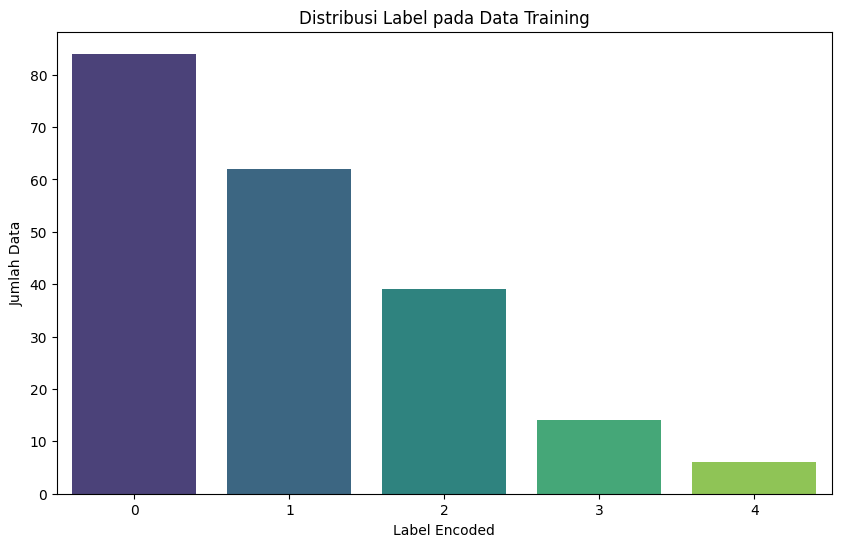

<ipython-input-6-74341dece008>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_encoded', data=test_data, palette='viridis')


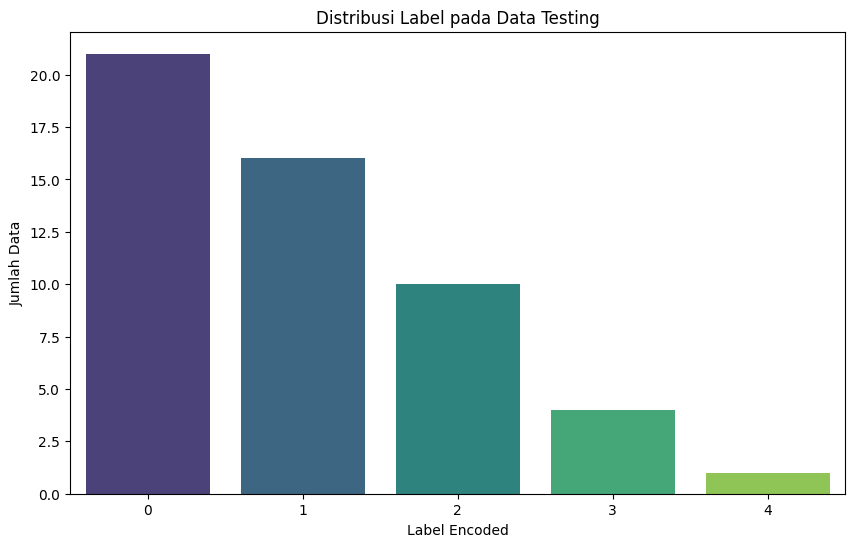

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi label pada data training
plt.figure(figsize=(10, 6))
sns.countplot(x='label_encoded', data=train_data, palette='viridis')
plt.title('Distribusi Label pada Data Training')
plt.xlabel('Label Encoded')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=0)
plt.show()

# Visualisasi distribusi label pada data testing
plt.figure(figsize=(10, 6))
sns.countplot(x='label_encoded', data=test_data, palette='viridis')
plt.title('Distribusi Label pada Data Testing')
plt.xlabel('Label Encoded')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=0)
plt.show()


#Ekstraksi Fitur

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack


def prepare_features(train_texts, test_texts, scenario):
    if scenario == "TF-IDF":  # Hanya menggunakan TF-IDF
        vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigram untuk TF-IDF
        X_train = vectorizer.fit_transform(train_texts)
        X_test = vectorizer.transform(test_texts)

    if scenario == "TF-IDF":  # Hanya menggunakan TF-IDF
        vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigram untuk TF-IDF
        X_train = vectorizer.fit_transform(train_texts)
        X_test = vectorizer.transform(test_texts)

    elif scenario == "TF-IDF + BOW":
        # Kombinasi TF-IDF dan BOW (Bag of Words)
        tfidf = TfidfVectorizer(ngram_range=(1, 1))  # Unigram untuk TF-IDF
        bow = CountVectorizer(ngram_range=(1, 1))  # Unigram untuk BOW
        X_train_tfidf = tfidf.fit_transform(train_texts)
        X_test_tfidf = tfidf.transform(test_texts)
        X_train_bow = bow.fit_transform(train_texts)
        X_test_bow = bow.transform(test_texts)
        X_train = hstack([X_train_tfidf, X_train_bow])  # Menggabungkan hasil TF-IDF dan BOW
        X_test = hstack([X_test_tfidf, X_test_bow])  # Menggabungkan hasil TF-IDF dan BOW

    elif scenario == "Unigram + TF-IDF":
        # TF-IDF unigram
        vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigram untuk TF-IDF
        X_train = vectorizer.fit_transform(train_texts)
        X_test = vectorizer.transform(test_texts)

    elif scenario == "Bigram + TF-IDF":
        # TF-IDF bigram
        vectorizer = TfidfVectorizer(ngram_range=(2, 2))  # Bigram untuk TF-IDF
        X_train = vectorizer.fit_transform(train_texts)
        X_test = vectorizer.transform(test_texts)

    elif scenario == "Trigram + TF-IDF":
        # TF-IDF trigram
        vectorizer = TfidfVectorizer(ngram_range=(3, 3))  # Trigram untuk TF-IDF
        X_train = vectorizer.fit_transform(train_texts)
        X_test = vectorizer.transform(test_texts)

    else:
        raise ValueError(f"Scenario '{scenario}' tidak dikenali!")

    return X_train, X_test


#Melatih Model Logistic Regression dengan SMOTE dan Hyperparameter Tuning

menghasilkan performa evaluasi yang paling optimal untuk setiap skenario ekstraksi fitur

=== Scenario: TF-IDF ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it 


Hyperparameter terbaik:
{'C': 100, 'max_iter': 1000, 'solver': 'saga'}
Akurasi: 0.6923
F1 Score: 0.6617
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        21
           1       0.75      0.94      0.83        16
           2       0.75      0.30      0.43        10
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         1

    accuracy                           0.69        52
   macro avg       0.63      0.46      0.48        52
weighted avg       0.72      0.69      0.66        52

=== Scenario: TF-IDF + BOW ===


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Hyperparameter terbaik:
{'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Akurasi: 0.6923
F1 Score: 0.6636
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.90      0.76        21
           1       0.87      0.81      0.84        16
           2       0.43      0.30      0.35        10
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         1

    accuracy                           0.69        52
   macro avg       0.59      0.45      0.47        52
weighted avg       0.69      0.69      0.66        52

=== Scenario: Unigram + TF-IDF ===


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/b

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Hyperparameter terbaik:
{'C': 100, 'max_iter': 1000, 'solver': 'saga'}
Akurasi: 0.6538
F1 Score: 0.6287
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.81      0.69        21
           1       0.72      0.81      0.76        16
           2       0.75      0.30      0.43        10
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         1

    accuracy                           0.65        52
   macro avg       0.62      0.43      0.46        52
weighted avg       0.69      0.65      0.63        52

=== Scenario: Bigram + TF-IDF ===


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Hyperparameter terbaik:
{'C': 100, 'max_iter': 2000, 'solver': 'saga'}
Akurasi: 0.6923
F1 Score: 0.5826
Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        21
           1       0.88      0.94      0.91        16
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1

    accuracy                           0.69        52
   macro avg       0.30      0.39      0.33        52
weighted avg       0.51      0.69      0.58        52

=== Scenario: Trigram + TF-IDF ===


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/b

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Hyperparameter terbaik:
{'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Akurasi: 0.6731
F1 Score: 0.5747
Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        21
           1       1.00      0.88      0.93        16
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1

    accuracy                           0.67        52
   macro avg       0.31      0.38      0.33        52
weighted avg       0.53      0.67      0.57        52


=== Hasil Semua Skenario ===
Scenario: TF-IDF, Akurasi: 0.6923, F1 Score: 0.6617
Scenario: TF-IDF + BOW, Akurasi: 0.6923, F1 Score: 0.6636
Scenario: Unigram + TF-IDF, Akurasi: 0.6538, F1 Score: 0.6287
Scenario: Bigram + TF-IDF, Akurasi: 0.6923, F1 Score: 0.5826
Scenario: Trigram + TF-IDF, Akurasi: 0.6731, F1 Score: 0.5747


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


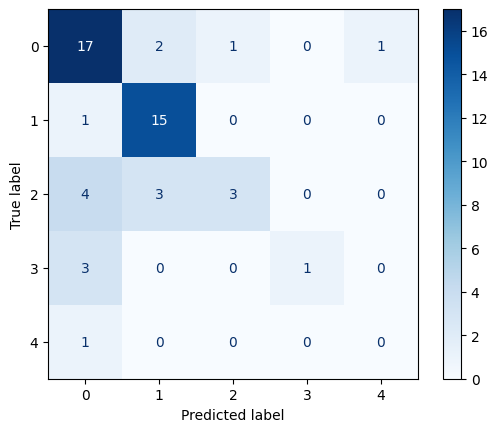

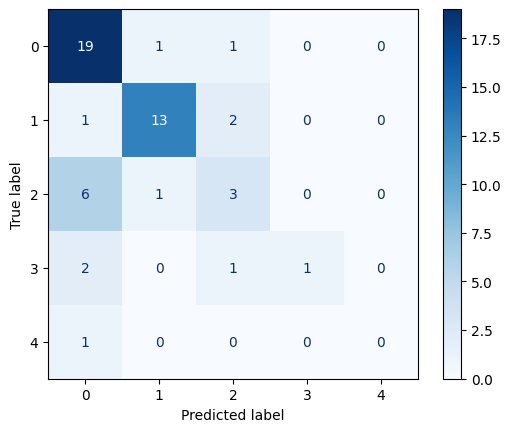

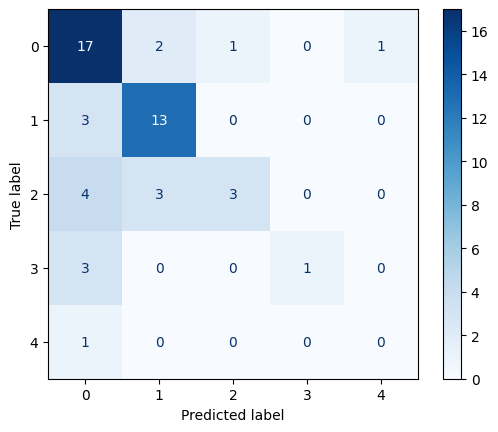

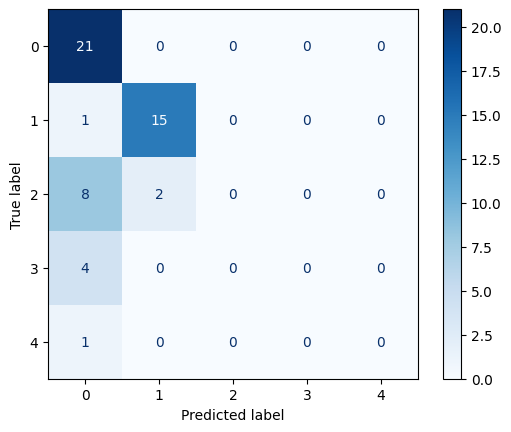

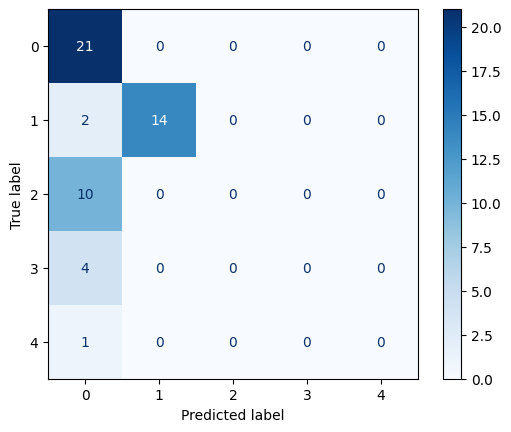

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Fungsi untuk melatih model dengan SMOTE dan Hyperparameter Tuning
def train_and_evaluate_with_smote_and_hyperparameter_tuning(train_texts, test_texts, train_labels, test_labels, scenario):
    print(f"=== Scenario: {scenario} ===")

    # Menyiapkan fitur berdasarkan skenario
    X_train, X_test = prepare_features(train_texts, test_texts, scenario)

    # Terapkan SMOTE untuk penyeimbangan data dengan k_neighbors lebih kecil (misal: 2)
    smote = SMOTE(random_state=42, k_neighbors=2)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, train_labels)

    # Model dasar Logistic Regression
    base_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

    # Hyperparameter Grid untuk GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularisasi
        'solver': ['lbfgs', 'saga'],   # Solver yang mendukung multinomial
        'max_iter': [1000, 2000]  # Jumlah iterasi
    }

    # GridSearchCV untuk tuning hyperparameter
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,  # Cross-validation 3-fold
        scoring='f1_weighted',  # Menggunakan F1 Score untuk evaluasi
        n_jobs=-1,  # Gunakan semua core yang tersedia
        verbose=2   # Output proses grid search
    )

    # Melatih model dengan GridSearchCV
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Model terbaik setelah tuning
    best_model = grid_search.best_estimator_
    print("\nHyperparameter terbaik:")
    print(grid_search.best_params_)

    # Prediksi langsung per username pada data uji
    y_pred = best_model.predict(X_test)

    # Evaluasi model dengan hyperparameter terbaik
    accuracy = accuracy_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred, average='weighted')
    class_report = classification_report(test_labels, y_pred)

    print(f"Akurasi: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(class_report)

    # Visualisasi Confusion Matrix hanya untuk model terbaik
    cm = confusion_matrix(test_labels, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_).plot(cmap='Blues')

    print("=" * 50)

    return accuracy, f1

# Daftar skenario ekstraksi fitur
scenarios = [
    "TF-IDF",
    "TF-IDF + BOW",
    "Unigram + TF-IDF",
    "Bigram + TF-IDF",
    "Trigram + TF-IDF",
]

# Menyimpan hasil untuk setiap skenario
results = []
for scenario in scenarios:
    accuracy, f1 = train_and_evaluate_with_smote_and_hyperparameter_tuning(X_train, X_test, y_train, y_test, scenario)
    results.append((scenario, accuracy, f1))

# Menampilkan hasil semua skenario
print("\n=== Hasil Semua Skenario ===")
for scenario, accuracy, f1 in results:
    print(f"Scenario: {scenario}, Akurasi: {accuracy:.4f}, F1 Score: {f1:.4f}")
